In [1]:
pip install pandas  matplotlib scikit-learn scipy

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [2]:
import time
import pandas as pd
import numpy as np
import h5py
import random
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from sklearn.preprocessing import MinMaxScaler
from itertools import islice
import pickle
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.models import Sequential
from keras.layers import Dense
from tensorflow.keras.layers import Dropout
from keras.activations import softmax
from keras.activations import relu
import gc
import itertools
from sklearn.metrics import mean_squared_error
import sklearn
from numpy import genfromtxt
from os import listdir
from os.path import isfile, join
import os
import copy
from scipy import interpolate
from scipy.spatial import distance
import time
import numpy as np

#np.set_printoptions(suppress=True)


def load_dataset(datasets,shape,labels):
    start = time.time()
    count = 1
    wavelength_list = []
    intensity_list = []
    label_list = []
    get_wavelength = True
    for dataset_name in datasets:
        with h5py.File(dataset_name, "r") as f:
            if get_wavelength: wavelengths = np.array(np.split(f['wavelength'][:], f['wavelength'][:].shape[0]//shape))
            intensities = np.array(np.split(f['intensity'][:], f['intensity'][:].shape[0]//shape))
            labels = np.array(np.split(f['label'][:], f['label'][:].shape[0]//labels))/100
            if get_wavelength: wavelength_list.append(wavelengths)
            intensity_list.append(intensities)
            label_list.append(labels)
            print(dataset_name, " Done")
        get_wavelength = False
    wavelengths = np.array(list(itertools.chain.from_iterable(wavelength_list)))
    intensities = np.array(list(itertools.chain.from_iterable(intensity_list)))
    labels = np.array(list(itertools.chain.from_iterable(label_list)))
    print(round(time.time()-start,2), "seconds")    
    return wavelengths, intensities, labels


## read whole dataset

In [3]:
datasets_to_load = ['dataset7.h5']
wavelengths_list, c, labels_list = load_dataset(datasets_to_load,4094,24)
current_elements = ['C', 'Mg', 'Al', 'Si', 'Ti', 'V', 'Fe', 'Co', 'Ni', 'Cu', 'Mn', 'Li', 'Zn', 'O', 'P', 'Pt', 'Au', 'Ag', 'Ir', 'W', 'Pd', 'Sn', 'Tc', 'Y']

dataset7.h5  Done
39.07 seconds


In [4]:
df_wavelengths=pd.DataFrame(wavelengths_list)
df_wavelengths.shape

(53660, 4094)

In [5]:
df_intensity=pd.DataFrame(c)
df_intensity.shape

(53660, 4094)

In [6]:
df_labels_list=pd.DataFrame(labels_list)
df_labels_list.head()

,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Remove gas elements

In [7]:
df_labels_list[13]!=0.0

0        False
1        False
2        False
3        False
4        False
         ...  
53655    False
53656    False
53657    False
53658    False
53659    False
Name: 13, Length: 53660, dtype: bool

In [8]:
#row 13 is 'O' which is gas element so droping all the rows which has oxygen
#get rows with gas elements .i.e. rows which has value other than 0 in column 13
rows_gas = df_labels_list[(df_labels_list[[13]] != 0.0).all(axis=1)]
rows_gas

,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
13,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.0
36,0.99,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.0
58,0.00,0.99,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.0
79,0.00,0.00,0.99,0.00,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.0
99,0.00,0.00,0.00,0.99,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53535,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.15,0.00,0.30,0.0
53536,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.15,0.00,0.00,0.3
53537,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.15,0.30,0.0
53538,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.15,0.00,0.3


In [9]:
rows_of_gas=rows_gas.index
rows_of_gas

Int64Index([   13,    36,    58,    79,    99,   118,   136,   153,   169,
              184,
            ...
            53530, 53531, 53532, 53533, 53534, 53535, 53536, 53537, 53538,
            53539],
           dtype='int64', length=5567)

In [10]:

df_intensity=df_intensity.drop(index=rows_of_gas)
df_intensity.shape

(48093, 4094)

In [11]:
df_wavelengths=df_wavelengths.drop(index=rows_of_gas)
df_wavelengths.shape

(48093, 4094)

In [12]:
df_labels_list=df_labels_list.drop(index=rows_of_gas)
df_labels_list.shape


(48093, 24)

In [13]:
df_labels_list=df_labels_list.drop(13, axis=1)
df_labels_list.shape

(48093, 23)

### Removing more elements ('Mn', 'Li', 'Zn', 'P', 'Pt', 'Au', 'Ag', 'Ir', 'W', 'Pd', 'Sn', 'Tc', 'Y')

In [14]:
#Mn
#read rows with values in it
Mn_rows = df_labels_list[(df_labels_list[[10]] != 0.0).all(axis=1)]
#get index values of rows
rows_of_Mn=Mn_rows.index
#drop those rows from intensity dataframe
df_intensity=df_intensity.drop(index=rows_of_Mn)
#drop those rows from labels dataframe
df_labels_list=df_labels_list.drop(index=rows_of_Mn)

In [15]:
df_labels_list=df_labels_list.drop(10, axis=1)
df_labels_list.shape

(42911, 22)

In [16]:
print("Shape of df_intensity :", df_intensity.shape)
print("Shape of df_labels_list :", df_labels_list.shape)

Shape of df_intensity : (42911, 4094)
Shape of df_labels_list : (42911, 22)


In [17]:
#Li
#read rows with values in it
Li_rows = df_labels_list[(df_labels_list[[11]] != 0.0).all(axis=1)]
#get index values of rows
rows_of_Li=Li_rows.index
#drop those rows from intensity dataframe
df_intensity=df_intensity.drop(index=rows_of_Li)
#drop those rows from labels dataframe
df_labels_list=df_labels_list.drop(index=rows_of_Li)

In [18]:
df_labels_list=df_labels_list.drop(11, axis=1)
df_labels_list.shape

(38101, 21)

In [19]:
print("Shape of df_intensity :", df_intensity.shape)
print("Shape of df_labels_list :", df_labels_list.shape)

Shape of df_intensity : (38101, 4094)
Shape of df_labels_list : (38101, 21)


In [20]:
#Zn
#read rows with values in it
Zn_rows = df_labels_list[(df_labels_list[[12]] != 0.0).all(axis=1)]
#get index values of rows
rows_of_Zn=Zn_rows.index
#drop those rows from intensity dataframe
df_intensity=df_intensity.drop(index=rows_of_Zn)
#drop those rows from labels dataframe
df_labels_list=df_labels_list.drop(index=rows_of_Zn)

In [21]:
df_labels_list=df_labels_list.drop(12, axis=1)
df_labels_list.shape

(33650, 20)

In [22]:
print("Shape of df_intensity :", df_intensity.shape)
print("Shape of df_labels_list :", df_labels_list.shape)

Shape of df_intensity : (33650, 4094)
Shape of df_labels_list : (33650, 20)


In [23]:
#P
#read rows with values in it
P_rows = df_labels_list[(df_labels_list[[14]] != 0.0).all(axis=1)]
#get index values of rows
rows_of_P=P_rows.index
#drop those rows from intensity dataframe
df_intensity=df_intensity.drop(index=rows_of_P)
#drop those rows from labels dataframe
df_labels_list=df_labels_list.drop(index=rows_of_P)

In [24]:
df_labels_list=df_labels_list.drop(14, axis=1)
df_labels_list.shape

(29545, 19)

In [25]:
print("Shape of df_intensity :", df_intensity.shape)
print("Shape of df_labels_list :", df_labels_list.shape)

Shape of df_intensity : (29545, 4094)
Shape of df_labels_list : (29545, 19)


In [26]:
#Pt
#read rows with values in it
Pt_rows = df_labels_list[(df_labels_list[[15]] != 0.0).all(axis=1)]
#get index values of rows
rows_of_Pt=Pt_rows.index
#drop those rows from intensity dataframe
df_intensity=df_intensity.drop(index=rows_of_Pt)
#drop those rows from labels dataframe
df_labels_list=df_labels_list.drop(index=rows_of_Pt)

In [27]:
df_labels_list=df_labels_list.drop(15, axis=1)
df_labels_list.shape

(25773, 18)

In [28]:
print("Shape of df_intensity :", df_intensity.shape)
print("Shape of df_labels_list :", df_labels_list.shape)

Shape of df_intensity : (25773, 4094)
Shape of df_labels_list : (25773, 18)


In [29]:
#Au
#read rows with values in it
Au_rows = df_labels_list[(df_labels_list[[16]] != 0.0).all(axis=1)]
#get index values of rows
rows_of_Au=Au_rows.index
#drop those rows from intensity dataframe
df_intensity=df_intensity.drop(index=rows_of_Au)
#drop those rows from labels dataframe
df_labels_list=df_labels_list.drop(index=rows_of_Au)

In [30]:
df_labels_list=df_labels_list.drop(16, axis=1)
df_labels_list.shape

(22321, 17)

In [31]:
print("Shape of df_intensity :", df_intensity.shape)
print("Shape of df_labels_list :", df_labels_list.shape)

Shape of df_intensity : (22321, 4094)
Shape of df_labels_list : (22321, 17)


In [32]:
#Ag
#read rows with values in it
Ag_rows = df_labels_list[(df_labels_list[[17]] != 0.0).all(axis=1)]
#get index values of rows
rows_of_Ag=Ag_rows.index
#drop those rows from intensity dataframe
df_intensity=df_intensity.drop(index=rows_of_Ag)
#drop those rows from labels dataframe
df_labels_list=df_labels_list.drop(index=rows_of_Ag)

In [33]:
df_labels_list=df_labels_list.drop(17, axis=1)
df_labels_list.shape

(19176, 16)

In [34]:
print("Shape of df_intensity :", df_intensity.shape)
print("Shape of df_labels_list :", df_labels_list.shape)

Shape of df_intensity : (19176, 4094)
Shape of df_labels_list : (19176, 16)


In [35]:
#Ir
#read rows with values in it
Ir_rows = df_labels_list[(df_labels_list[[18]] != 0.0).all(axis=1)]
#get index values of rows
rows_of_Ir=Ir_rows.index
#drop those rows from intensity dataframe
df_intensity=df_intensity.drop(index=rows_of_Ir)
#drop those rows from labels dataframe
df_labels_list=df_labels_list.drop(index=rows_of_Ir)

In [36]:
df_labels_list=df_labels_list.drop(18, axis=1)
df_labels_list.shape

(16325, 15)

In [37]:
print("Shape of df_intensity :", df_intensity.shape)
print("Shape of df_labels_list :", df_labels_list.shape)

Shape of df_intensity : (16325, 4094)
Shape of df_labels_list : (16325, 15)


In [38]:
#W
#read rows with values in it
W_rows = df_labels_list[(df_labels_list[[19]] != 0.0).all(axis=1)]
#get index values of rows
rows_of_W=W_rows.index
#drop those rows from intensity dataframe
df_intensity=df_intensity.drop(index=rows_of_W)
#drop those rows from labels dataframe
df_labels_list=df_labels_list.drop(index=rows_of_W)

In [39]:
df_labels_list=df_labels_list.drop(19, axis=1)
df_labels_list.shape

(13755, 14)

In [40]:
print("Shape of df_intensity :", df_intensity.shape)
print("Shape of df_labels_list :", df_labels_list.shape)

Shape of df_intensity : (13755, 4094)
Shape of df_labels_list : (13755, 14)


In [41]:
#Pd
#read rows with values in it
Pd_rows = df_labels_list[(df_labels_list[[20]] != 0.0).all(axis=1)]
#get index values of rows
rows_of_Pd=Pd_rows.index
#drop those rows from intensity dataframe
df_intensity=df_intensity.drop(index=rows_of_Pd)
#drop those rows from labels dataframe
df_labels_list=df_labels_list.drop(index=rows_of_Pd)

In [42]:
df_labels_list=df_labels_list.drop(20, axis=1)
df_labels_list.shape

(11453, 13)

In [43]:
print("Shape of df_intensity :", df_intensity.shape)
print("Shape of df_labels_list :", df_labels_list.shape)

Shape of df_intensity : (11453, 4094)
Shape of df_labels_list : (11453, 13)


In [44]:
#Sn
#read rows with values in it
Sn_rows = df_labels_list[(df_labels_list[[21]] != 0.0).all(axis=1)]
#get index values of rows
rows_of_Sn=Sn_rows.index
#drop those rows from intensity dataframe
df_intensity=df_intensity.drop(index=rows_of_Sn)
#drop those rows from labels dataframe
df_labels_list=df_labels_list.drop(index=rows_of_Sn)

In [45]:
df_labels_list=df_labels_list.drop(21, axis=1)
df_labels_list.shape

(9406, 12)

In [46]:
print("Shape of df_intensity :", df_intensity.shape)
print("Shape of df_labels_list :", df_labels_list.shape)

Shape of df_intensity : (9406, 4094)
Shape of df_labels_list : (9406, 12)


In [47]:
#Tc
#read rows with values in it
Tc_rows = df_labels_list[(df_labels_list[[22]] != 0.0).all(axis=1)]
#get index values of rows
rows_of_Tc=Tc_rows.index
#drop those rows from intensity dataframe
df_intensity=df_intensity.drop(index=rows_of_Tc)
#drop those rows from labels dataframe
df_labels_list=df_labels_list.drop(index=rows_of_Tc)

In [48]:
df_labels_list=df_labels_list.drop(22, axis=1)
df_labels_list.shape

(7601, 11)

In [49]:
print("Shape of df_intensity :", df_intensity.shape)
print("Shape of df_labels_list :", df_labels_list.shape)

Shape of df_intensity : (7601, 4094)
Shape of df_labels_list : (7601, 11)


In [50]:
#Y
#read rows with values in it
Y_rows = df_labels_list[(df_labels_list[[23]] != 0.0).all(axis=1)]
#get index values of rows
rows_of_Y=Y_rows.index
#drop those rows from intensity dataframe
df_intensity=df_intensity.drop(index=rows_of_Y)
#drop those rows from labels dataframe
df_labels_list=df_labels_list.drop(index=rows_of_Y)

In [51]:
df_labels_list=df_labels_list.drop(23, axis=1)
df_labels_list.shape

(6025, 10)

In [54]:
print("Shape of df_intensity :", df_intensity.shape)
print("Shape of df_labels_list :", df_labels_list.shape)

Shape of df_intensity : (6025, 4094)
Shape of df_labels_list : (6025, 10)


In [ ]:
#Sn
#read rows with values in it
Sn_rows = df_labels_list[(df_labels_list[[21]] != 0.0).all(axis=1)]
#get index values of rows
rows_of_Sn=Sn_rows.index
#drop those rows from intensity dataframe
df_intensity=df_intensity.drop(index=rows_of_Sn)
#drop those rows from labels dataframe
df_labels_list=df_labels_list.drop(index=rows_of_Sn)

In [ ]:
df_labels_list=df_labels_list.drop(21, axis=1)
df_labels_list.shape

In [ ]:
print("Shape of df_intensity :", df_intensity.shape)
print("Shape of df_labels_list :", df_labels_list.shape)

In [ ]:
#Sn
#read rows with values in it
Sn_rows = df_labels_list[(df_labels_list[[21]] != 0.0).all(axis=1)]
#get index values of rows
rows_of_Sn=Sn_rows.index
#drop those rows from intensity dataframe
df_intensity=df_intensity.drop(index=rows_of_Sn)
#drop those rows from labels dataframe
df_labels_list=df_labels_list.drop(index=rows_of_Sn)

In [ ]:
df_labels_list=df_labels_list.drop(21, axis=1)
df_labels_list.shape

## split dataset for train set and test set

In [55]:
x=df_intensity
y=df_labels_list

In [56]:
# Split x into train and test sets
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.1, random_state=42)

In [57]:
# Print the shape of the resulting data sets
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X_train shape: (5422, 4094)
y_train shape: (5422, 10)
X_test shape: (603, 4094)
y_test shape: (603, 10)


In [69]:
# Compile the model
def create_model(my_learning_rate):
    model = tf.keras.models.Sequential()
    #model.add(Dense(6025, batch_input_shape=(None,4094), activation=relu,name="input"))
    #model.add(Dense(5422, batch_input_shape=(None,4094), activation=relu,name="layer_1"))
    #model.add(Dense(5200, batch_input_shape=(None,4094), activation=relu,name="layer_2"))
    #model.add(Dense(4800, batch_input_shape=(None,4094), activation=relu,name="layer_3"))
    model.add(Dense(4600, batch_input_shape=(None,4094), activation=relu,name="layer_4"))
    model.add(Dense(4296, batch_input_shape=(None,4094), activation=relu,name="layer_5"))
    model.add(Dense(3748, batch_input_shape=(None,4094), activation=relu,name="layer_6"))
    model.add(Dense(3248, batch_input_shape=(None,4094), activation=relu,name="layer_7"))
    model.add(Dense(2548, batch_input_shape=(None,4094), activation=relu,name="layer_8"))
    model.add(Dense(2000, batch_input_shape=(None,4094), activation=relu,name="layer_9"))
        
    model.add(Dense(1024, batch_input_shape=(None,4094), activation=relu,name="layer_11"))   
    model.add(Dense(512, batch_input_shape=(None,4094), activation=relu,name="layer_12"))
    model.add(Dense(256, batch_input_shape=(None,4094), activation=relu,name="layer_13"))
    model.add(Dense(128, batch_input_shape=(None,4094), activation=relu,name="layer_14"))
    model.add(Dense(10, activation=softmax,name="output"))
    
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=my_learning_rate), loss='categorical_crossentropy', metrics=['accuracy'])
    return model 


In [70]:
# Train the model
def train_model(model, train_features, train_label, epochs,
                batch_size=None, validation_split=0.2):
  """Train the model by feeding it data."""

  history = model.fit(x=train_features, y=train_label, batch_size=batch_size,
                      epochs=epochs, shuffle=True, verbose=2,
                      validation_split=validation_split)
 
  # To track the progression of training, gather a snapshot
  # of the model's metrics at each epoch. 
  epochs = history.epoch
  hist = pd.DataFrame(history.history)

  return epochs, hist    

In [147]:
# The following variables are the hyperparameters.
learning_rate = 0.001
epochs = 150
batch_size = 64
validation_split = 0.2


In [148]:
# Establish the model's topography.
my_model = create_model(learning_rate)

# Train the model on the normalized training set.
epochs, hist = train_model(my_model, X_train, y_train, epochs, batch_size, validation_split)

Epoch 1/150
68/68 - 1s - loss: 435763.3750 - accuracy: 0.1091 - val_loss: 15256.0557 - val_accuracy: 0.0949 - 1s/epoch - 19ms/step
Epoch 2/150
68/68 - 1s - loss: 6029.1050 - accuracy: 0.1139 - val_loss: 28673.8711 - val_accuracy: 0.1143 - 647ms/epoch - 10ms/step
Epoch 3/150
68/68 - 1s - loss: 7762.7529 - accuracy: 0.1118 - val_loss: 689.0651 - val_accuracy: 0.1263 - 651ms/epoch - 10ms/step
Epoch 4/150
68/68 - 1s - loss: 7009.5967 - accuracy: 0.1349 - val_loss: 4065.9185 - val_accuracy: 0.1954 - 647ms/epoch - 10ms/step
Epoch 5/150
68/68 - 1s - loss: 2291.4231 - accuracy: 0.1690 - val_loss: 624.1293 - val_accuracy: 0.3447 - 644ms/epoch - 9ms/step
Epoch 6/150
68/68 - 1s - loss: 1867.5433 - accuracy: 0.2573 - val_loss: 1666.4629 - val_accuracy: 0.3456 - 652ms/epoch - 10ms/step
Epoch 7/150
68/68 - 1s - loss: 3241.0208 - accuracy: 0.2875 - val_loss: 4578.3857 - val_accuracy: 0.3032 - 642ms/epoch - 9ms/step
Epoch 8/150
68/68 - 1s - loss: 4217.3931 - accuracy: 0.2499 - val_loss: 2391.7532 - va

In [135]:
#epochs= 100 lr=0.05
my_model.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 layer_4 (Dense)             (None, 4600)              18837000  
                                                                 
 layer_5 (Dense)             (None, 4296)              19765896  
                                                                 
 layer_6 (Dense)             (None, 3748)              16105156  
                                                                 
 layer_7 (Dense)             (None, 3248)              12176752  
                                                                 
 layer_8 (Dense)             (None, 2548)              8278452   
                                                                 
 layer_9 (Dense)             (None, 2000)              5098000   
                                                                 
 layer_11 (Dense)            (None, 1024)            

In [137]:
#epoch=300 lr=0.001 batch=128
print("\n Evaluate the new model against the test set:")
my_model.evaluate(x=X_train, y=y_train, batch_size=batch_size)


 Evaluate the new model against the test set:
43/43 [==============================] - 0s 4ms/step - loss: 0.7141 - accuracy: 0.8768


[0.714129626750946, 0.8767982125282288]

In [127]:
#epoch=300 lr=0.001 batch=64
print("\n Evaluate the new model against the test set:")
my_model.evaluate(x=X_train, y=y_train, batch_size=batch_size)


 Evaluate the new model against the test set:
85/85 [==============================] - 0s 3ms/step - loss: 2.2697 - accuracy: 0.1092


[2.2696526050567627, 0.10918480157852173]

In [149]:
#epoch=150 lr=0.001 batch=64
print("\n Evaluate the new model against the test set:")
my_model.evaluate(x=X_train, y=y_train, batch_size=batch_size)


 Evaluate the new model against the test set:
85/85 [==============================] - 0s 3ms/step - loss: 1.2702 - accuracy: 0.6575


[1.2702330350875854, 0.6575064659118652]

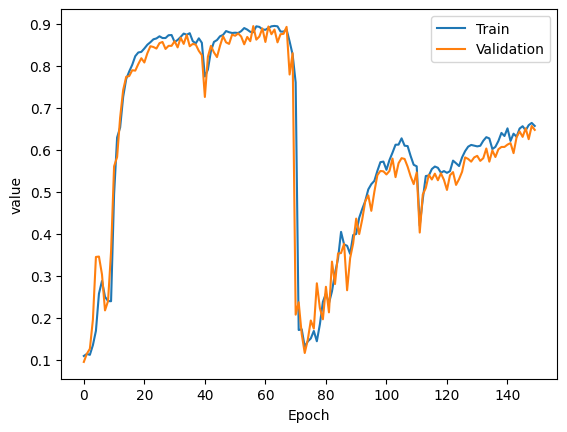

In [150]:
#epoch=150 lr=0.001 batch=64
plt.plot(hist['accuracy'], label='Train')
plt.plot(hist['val_accuracy'], label='Validation')
plt.ylabel('value')
plt.xlabel('Epoch')
plt.legend(loc='upper right')

In [145]:
#epoch=150 lr=0.001 batch=128
print("\n Evaluate the new model against the test set:")
my_model.evaluate(x=X_train, y=y_train, batch_size=batch_size)


 Evaluate the new model against the test set:
43/43 [==============================] - 0s 4ms/step - loss: 0.6838 - accuracy: 0.8978


[0.6838462948799133, 0.897823691368103]

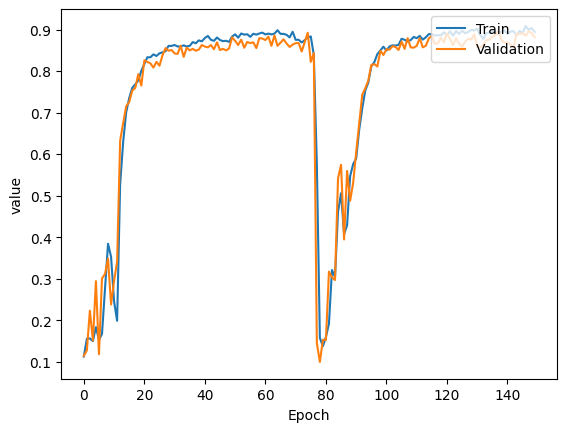

In [146]:
#epoch=150 lr=0.001 batch=128
plt.plot(hist['accuracy'], label='Train')
plt.plot(hist['val_accuracy'], label='Validation')
plt.ylabel('value')
plt.xlabel('Epoch')
plt.legend(loc='upper right')

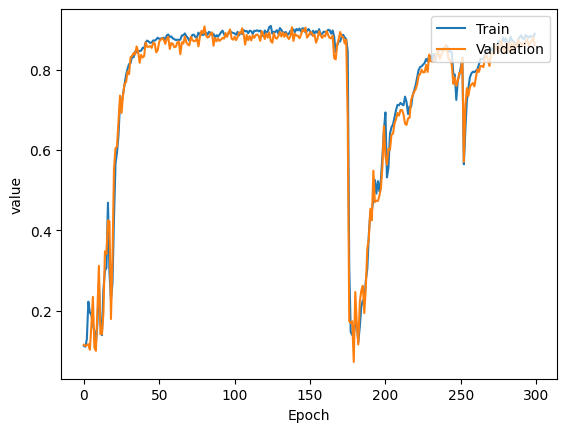

In [138]:
#epoch=300 lr=0.001 batch=128
plt.plot(hist['accuracy'], label='Train')
plt.plot(hist['val_accuracy'], label='Validation')
plt.ylabel('value')
plt.xlabel('Epoch')
plt.legend(loc='upper right')

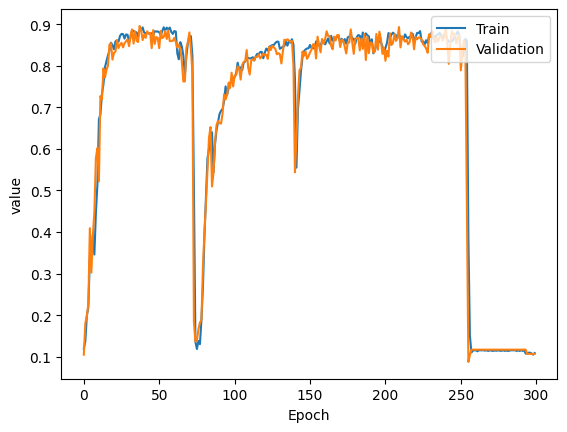

In [126]:
#epoch=300 lr=0.001 batch=64
plt.plot(hist['accuracy'], label='Train')
plt.plot(hist['val_accuracy'], label='Validation')
plt.ylabel('value')
plt.xlabel('Epoch')
plt.legend(loc='upper right')

In [141]:
#epoch=200 lr=0.001 batch=128
print("\n Evaluate the new model against the test set:")
my_model.evaluate(x=X_train, y=y_train, batch_size=batch_size)


 Evaluate the new model against the test set:
43/43 [==============================] - 0s 4ms/step - loss: 2.2434 - accuracy: 0.4899


[2.2434377670288086, 0.48985615372657776]

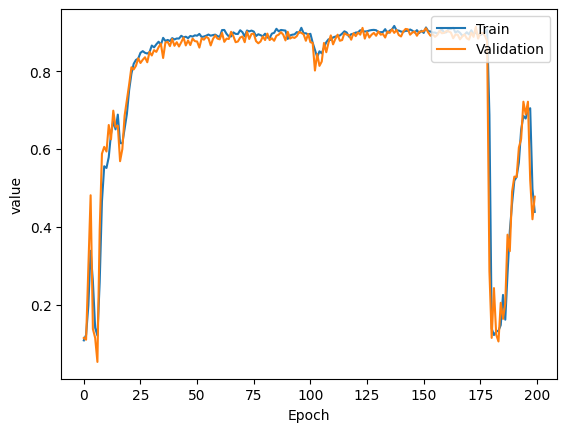

In [142]:
#epoch=200 lr=0.001 batch=128
plt.plot(hist['accuracy'], label='Train')
plt.plot(hist['val_accuracy'], label='Validation')
plt.ylabel('value')
plt.xlabel('Epoch')
plt.legend(loc='upper right')

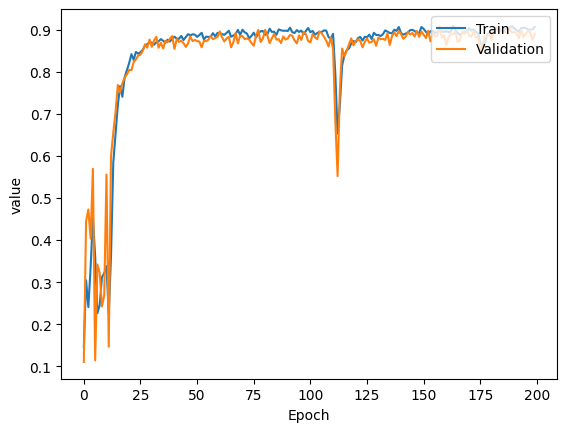

In [108]:
#epoch=200 lr=0.001 batch=128
plt.plot(hist['accuracy'], label='Train')
plt.plot(hist['val_accuracy'], label='Validation')
plt.ylabel('value')
plt.xlabel('Epoch')
plt.legend(loc='upper right')

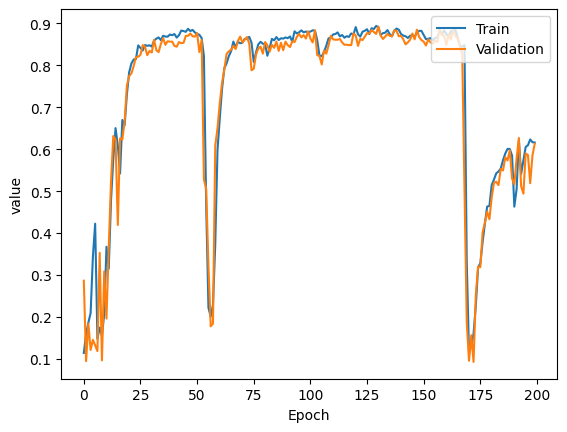

In [132]:
#epoch=200 lr=0.001 batch=64
plt.plot(hist['accuracy'], label='Train')
plt.plot(hist['val_accuracy'], label='Validation')
plt.ylabel('value')
plt.xlabel('Epoch')
plt.legend(loc='upper right')

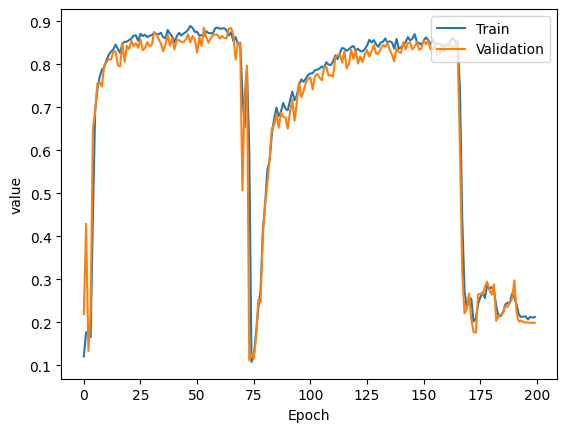

In [97]:
#epoch=200 lr=0.001 batch=64
plt.plot(hist['accuracy'], label='Train')
plt.plot(hist['val_accuracy'], label='Validation')
plt.ylabel('value')
plt.xlabel('Epoch')
plt.legend(loc='upper right')

In [109]:
predictions = my_model.predict(X_test)

19/19 [==============================] - 0s 2ms/step


In [121]:
predictions.shape

(603, 10)

In [110]:
df_predictions = pd.DataFrame(predictions)
df_predictions

,0,1,2,3,4,5,6,7,8,9
0,0.007515,3.669100e-04,0.000145,0.003590,0.000805,0.015822,9.702281e-01,0.001286,0.000064,0.000177
1,0.004710,1.387598e-04,0.000004,0.000221,0.000134,0.000928,7.333615e-01,0.259547,0.000279,0.000677
2,0.000032,3.289161e-05,0.000047,0.306545,0.000018,0.000002,4.704220e-10,0.693248,0.000009,0.000067
3,0.000014,6.883368e-05,0.000273,0.506486,0.000087,0.000009,1.103190e-08,0.492833,0.000016,0.000214
4,0.003996,1.330758e-04,0.000402,0.000260,0.000053,0.276700,1.644074e-04,0.718216,0.000019,0.000056
...,...,...,...,...,...,...,...,...,...,...
598,0.534299,1.985127e-03,0.006204,0.214915,0.136290,0.001373,5.132728e-03,0.007081,0.010419,0.082303
599,0.001408,2.000830e-07,0.000209,0.000507,0.250474,0.747216,1.546092e-04,0.000005,0.000024,0.000002
600,0.002407,5.615106e-04,0.000011,0.001525,0.000411,0.000615,3.534895e-01,0.639987,0.000445,0.000549
601,0.604010,8.271609e-05,0.000109,0.000274,0.000155,0.395146,8.778110e-05,0.000112,0.000004,0.000019


In [111]:
df_predictions_original = pd.DataFrame(y_test)
df_predictions_original

,0,1,2,3,4,5,6,7,8,9
26625,0.00,0.0,0.0,0.00,0.00,0.03,0.97,0.00,0.0,0.0
6771,0.00,0.0,0.0,0.00,0.00,0.00,0.75,0.25,0.0,0.0
15825,0.00,0.0,0.0,0.42,0.00,0.00,0.00,0.58,0.0,0.0
10581,0.00,0.0,0.0,0.61,0.00,0.00,0.00,0.39,0.0,0.0
20002,0.00,0.0,0.0,0.00,0.00,0.27,0.00,0.73,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
33463,0.40,0.0,0.0,0.40,0.20,0.00,0.00,0.00,0.0,0.0
18602,0.00,0.0,0.0,0.00,0.32,0.68,0.00,0.00,0.0,0.0
16431,0.00,0.0,0.0,0.00,0.00,0.00,0.40,0.60,0.0,0.0
11344,0.58,0.0,0.0,0.00,0.00,0.42,0.00,0.00,0.0,0.0


In [112]:
#selecting a row from df_intensity for predection
test_1 =df_intensity.iloc[1]
test_1=pd.DataFrame(test_1)
test_row=test_1.T

In [113]:
raw_1_predictions = my_model.predict(test_row)
raw_1_predictions

1/1 [==============================] - 0s 22ms/step


array([[4.0616065e-02, 9.5813435e-01, 4.2456089e-05, 1.0696658e-03,
        1.0294044e-06, 3.9793875e-07, 8.8305555e-08, 8.3570491e-11,
        4.6151232e-05, 8.9774010e-05]], dtype=float32)

In [114]:
raw_1_predictions_df=pd.DataFrame(raw_1_predictions)
raw_1_predictions_df

,0,1,2,3,4,5,6,7,8,9
0,0.040616,0.958134,0.000042,0.00107,0.000001,3.979387e-07,8.830555e-08,8.357049e-11,0.000046,0.00009


In [119]:
row_1_original_values=df_labels_list.iloc[1]
row_1_original_values_df=pd.DataFrame(row_1_original_values)
row_1_original_values_df

,1
0,0.0
1,1.0
2,0.0
3,0.0
4,0.0
5,0.0
6,0.0
7,0.0
8,0.0
9,0.0


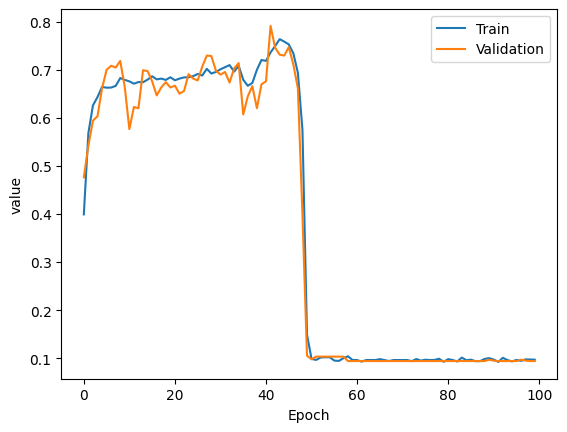

In [92]:
#epoch=100 lr=0.0001 batch=32
plt.plot(hist['accuracy'], label='Train')
plt.plot(hist['val_accuracy'], label='Validation')
plt.ylabel('value')
plt.xlabel('Epoch')
plt.legend(loc='upper right')

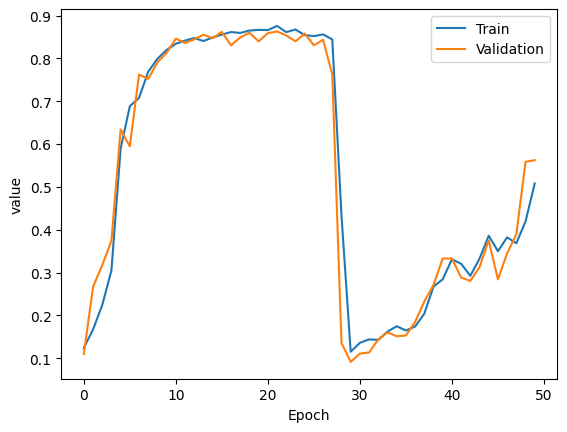

In [80]:
#epoch=50 lr=0.001 batch=32
plt.plot(hist['accuracy'], label='Train')
plt.plot(hist['val_accuracy'], label='Validation')
plt.ylabel('value')
plt.xlabel('Epoch')
plt.legend(loc='upper right')